In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from math import sqrt
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'C:\Users\o\Downloads\TrafficPredictionatJunctions\traffic.csv')
df.shape

(48120, 4)

In [3]:
df.tail()

,DateTime,Junction,Vehicles,ID
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224
48119,2017-06-30 23:00:00,4,12,20170630234


In [4]:
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [5]:
df.ID.nunique()

48120

In [6]:
df.Junction.value_counts() / len(df) * 100

3    30.324190
2    30.324190
1    30.324190
4     9.027431
Name: Junction, dtype: float64

##### The data seems to be at every hour of interval at 4 different junctions. 
##### Junction-4 seems to have limited data as compare to the other junctions.

#### Parse the datetime and remove ID as ID is a unique identifier and does not help in any prediction
##### Extract Year and Month from DateTime

In [7]:
df["DateTime"]= pd.to_datetime(df["DateTime"])
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df["Date_num"] = df['DateTime'].dt.day
df["Week_num"] = df.DateTime.dt.strftime("%V").astype('int64')
df["Hour"]     = df['DateTime'].dt.hour
df["WeekDay"]  = df.DateTime.dt.strftime("%A")

# drop ID column
df.drop(["ID"], axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   Year      48120 non-null  int64         
 4   Month     48120 non-null  int64         
 5   Date_num  48120 non-null  int64         
 6   Week_num  48120 non-null  int64         
 7   Hour      48120 non-null  int64         
 8   WeekDay   48120 non-null  object        
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 3.3+ MB


In [10]:
df.head(2)

,DateTime,Junction,Vehicles,Year,Month,Date_num,Week_num,Hour,WeekDay
0,2015-11-01 00:00:00,1,15,2015,11,1,44,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,44,1,Sunday


In [11]:
GrpbyCol = ['Junction', 'Year', 'Month', 'Date_num', 'Week_num', 'Hour', 'WeekDay']
for i in GrpbyCol:
    print("--------New Column-------------\n", i, "\n", df.groupby(i)['Vehicles'].sum().reset_index(), "\n")

--------New Column-------------
 Junction 
    Junction  Vehicles
0         1    657412
1         2    207983
2         3    199823
3         4     31501 

--------New Column-------------
 Year 
    Year  Vehicles
0  2015     50552
1  2016    563588
2  2017    482579 

--------New Column-------------
 Month 
     Month  Vehicles
0       1    102740
1       2    109668
2       3    120166
3       4    123250
4       5    128291
5       6    131202
6       7     48742
7       8     48962
8       9     55393
9      10     59262
10     11     84388
11     12     84655 

--------New Column-------------
 Date_num 
     Date_num  Vehicles
0          1     34676
1          2     36217
2          3     35349
3          4     33737
4          5     34167
5          6     35179
6          7     34750
7          8     35180
8          9     36431
9         10     35373
10        11     33643
11        12     35099
12        13     35169
13        14     34468
14        15     36007
15        16   

### Basic Findings
* Traffic is more at Junction-1 overall across all the years and maximum in year 2016
* Across all the junctions and years (aggregated), traffic decreases from July onwards and then again starts rising from October. But, this is because Junction-4 has only 2017 second half data
* 31st has low traffic and could be that most of the employees take last day off or work from home or it is usually a public holiday
* Week 27 and Week 53 has a significantly low traffic across all the junctions over the years - due to the year 2017
* Surprisingly more traffic during late night hours till midnight. Traffic from 10am onwards starts increasing which is expected as people go to the work
* Weekend has a low traffic as compare to Weekdays - can be attribute to the fact that people try to relax at home during the weekends and more for work during weekdays 

In [12]:
df.describe(include='all')

,DateTime,Junction,Vehicles,Year,Month,Date_num,Week_num,Hour,WeekDay
count,48120,48120.000000,48120.000000,48120.000000,48120.000000,48120.000000,48120.000000,48120.000000,48120
unique,14592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
top,2017-06-09 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Friday
freq,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6888
first,2015-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-06-30 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.180549,22.791334,2016.269825,5.884289,15.700748,23.941646,11.500000,NaN
std,NaN,0.966955,20.750063,0.616093,3.569872,8.784073,15.718066,6.922258,NaN
min,NaN,1.000000,1.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,NaN
25%,NaN,1.000000,9.000000,2016.000000,3.000000,8.000000,11.000000,5.750000,NaN


#### Basic Desriptive Stats Findings:
* Minimum Vehicle count at any junction is 1 and Maximum is 180 at any given point of time indicating our data has both crowded and clear traffic pattern. Average vehicle count is 21
* Data is sprad from 2015 till 2017, Jan to Dec, Week1 to Week53 (53rd week was in 2017 only), Midnight to Midnight (24hrs), 7Weekdays (Sunday-Sunday), 1st-31st Date (include both 30th and 31st)

In [13]:
df.drop_duplicates().shape # no duplicates

(48120, 9)

#### The data does not have any duplicates and also have no nuances!
#### Let's create some charts to understand the traffic pattern at different time intervals and junctions

#### First Check the distribution of the variables and correlation all together 

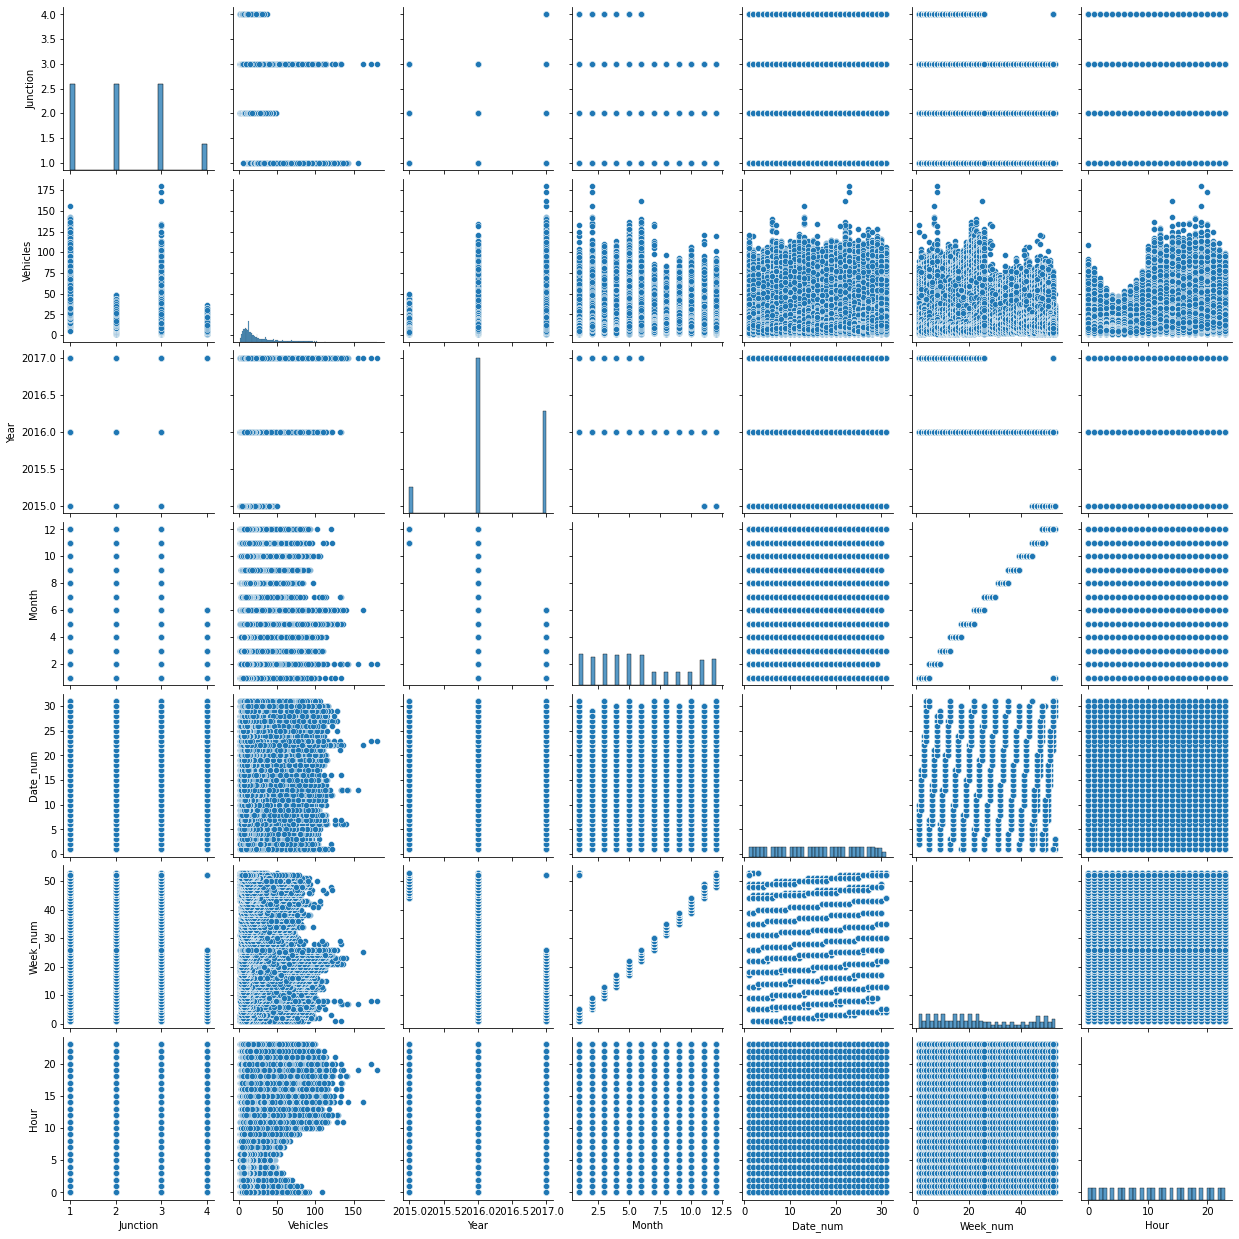

In [14]:
sns.pairplot(df)

#### the graph shows following:
* Week_num and Month has a perfect linear relationship
* Vehicles distirbution are kind of skewed
* Vehicles by hiurs shows less traffic from midnight to 8am-10am
* Week number and Month distribution is not uniform so some weeks and months has low traffic
* Vehicles count (traffic) is increasing over the years 

Text(0.5, 0, 'DateTime')

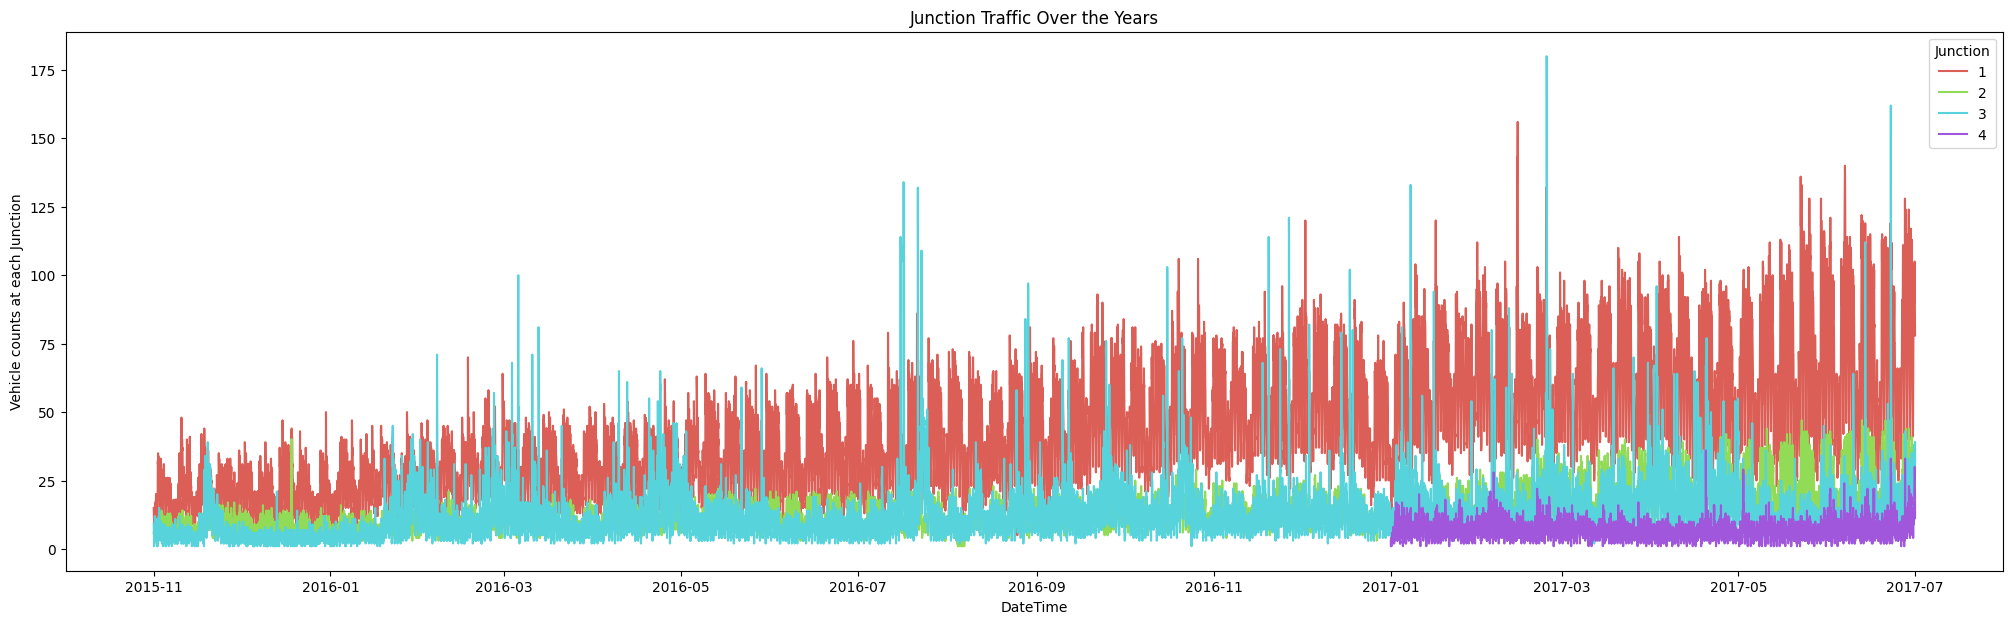

In [15]:
plt.figure(figsize=(25,7))
colors = sns.color_palette("hls", 4)
_ = sns.lineplot(x=df['DateTime'], y="Vehicles", data=df, hue="Junction", palette=colors)
_.set_title("Junction Traffic Over the Years")
_.set_ylabel("Vehicle counts at each Junction")
_.set_xlabel("DateTime")

### Trend we can see in the above graph
* Junction-1 has the highest total vehicle counts which was evident in the above groupby too. It also has an upward treand meaning traffic keep increasing over the years
* Junction-2 has the most peak bars meaning some high count of vehicles for a certain month - can be treated as outliers but need to look further
* Junction-3 has slight upward trend but kind of constant flow over the years
* Junction-4 has limited data that we saw in our above eda part as well; only 2017 partial data present

Text(0.5, 0, 'WeekDays')

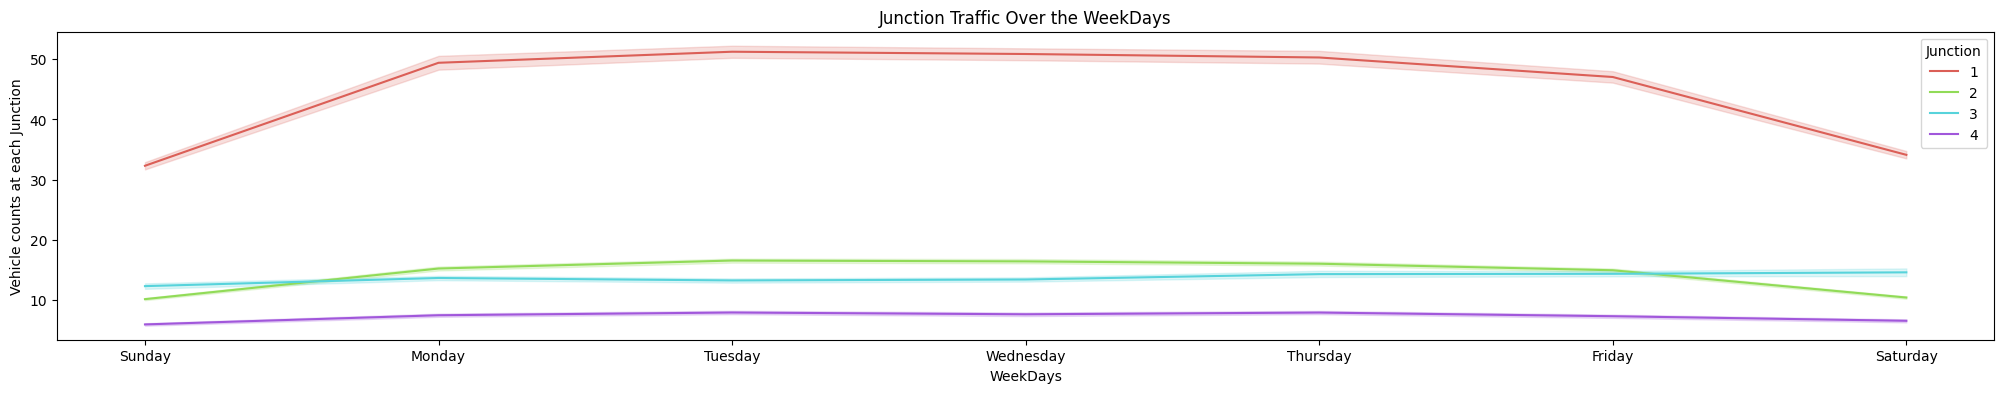

In [16]:
plt.figure(figsize=(25,4))
colors = sns.color_palette("hls", 4)
_ = sns.lineplot(x=df['WeekDay'], y="Vehicles", data=df, hue="Junction", palette=colors)
_.set_title("Junction Traffic Over the WeekDays")
_.set_ylabel("Vehicle counts at each Junction")
_.set_xlabel("WeekDays")

##### It is confirming the above findings that Saturday & Sunday there is less traffic across all the Junctions as compare to the weekdays (Mon-Fri)

Text(0.5, 0, 'Hours')

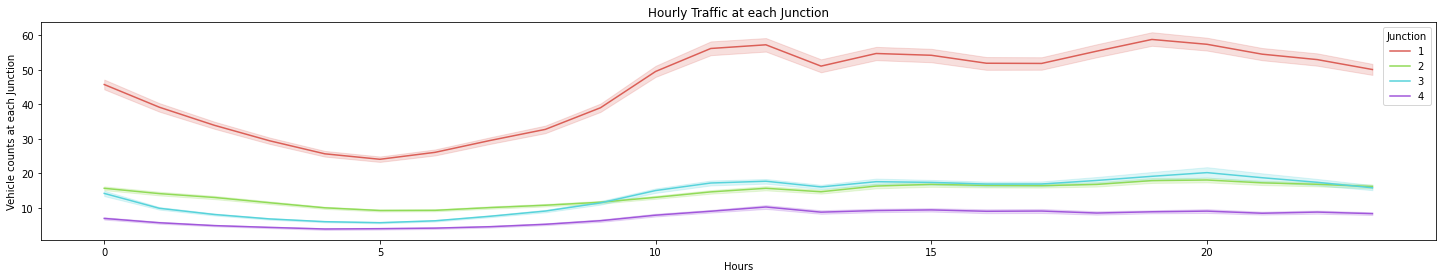

In [17]:
plt.figure(figsize=(25,4))
colors = sns.color_palette("hls", 4)
_ = sns.lineplot(x=df['Hour'], y="Vehicles", data=df, hue="Junction", palette=colors)
_.set_title("Hourly Traffic at each Junction")
_.set_ylabel("Vehicle counts at each Junction")
_.set_xlabel("Hours")

##### It is confirming the above findings that from midnight to morning 8am-10am there is less traffic across all the Junctions as compare to rest of the time

Text(0.5, 0, 'Number of Weeks')

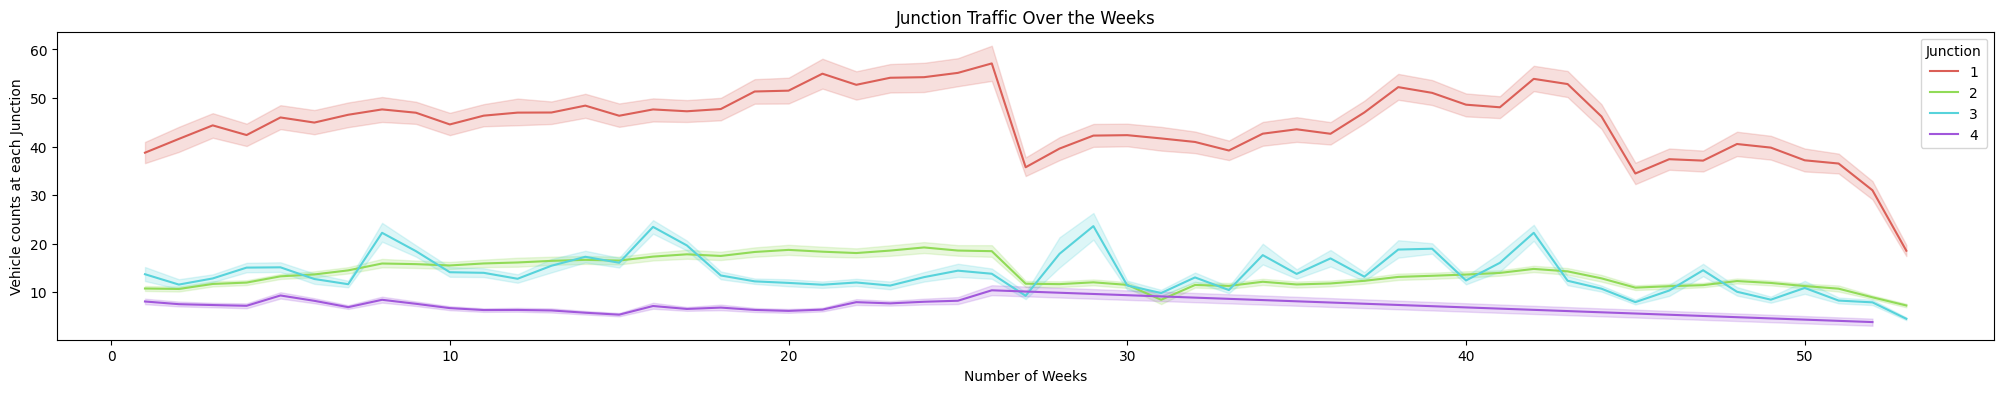

In [17]:
plt.figure(figsize=(25,4))
colors = sns.color_palette("hls", 4)
_ = sns.lineplot(x=df['Week_num'], y="Vehicles", data=df, hue="Junction", palette=colors)
_.set_title("Junction Traffic Over the Weeks")
_.set_ylabel("Vehicle counts at each Junction")
_.set_xlabel("Number of Weeks")

##### It is confirming the above findings that Week-27 has a huge dip in traffic across all the Junctions at Junction-4. It can be due to is the last week of June and first week of July meaning Summer break and less traffic on road. Similarly, during the end of the year, i.e., November-December because of Thanksgiving, Christmas, Annual leave there is less traffic across all the junctions.

Text(0.5, 0, 'Dates of a Month ')

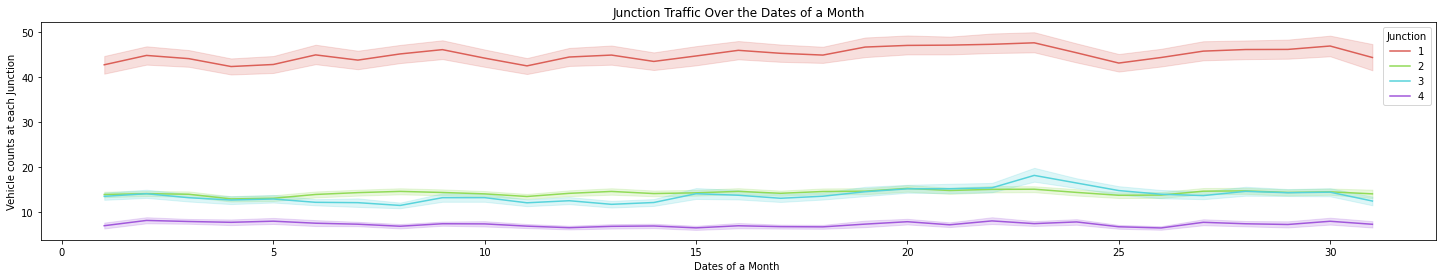

In [19]:
plt.figure(figsize=(25,4))
colors = sns.color_palette("hls", 4)
_ = sns.lineplot(x=df['Date_num'], y="Vehicles", data=df, hue="Junction", palette=colors)
_.set_title("Junction Traffic Over the Dates of a Month")
_.set_ylabel("Vehicle counts at each Junction")
_.set_xlabel("Dates of a Month ")

##### Traffic is pretty stagnant across al the dates of a month

Text(0.5, 0, 'Months')

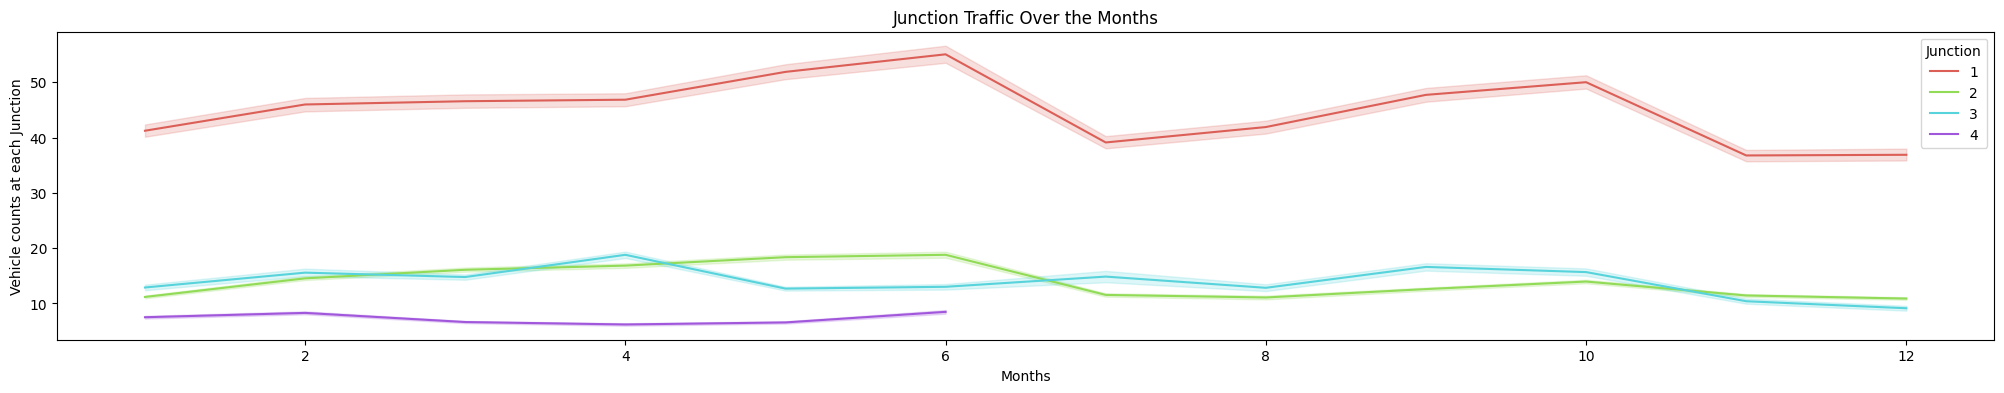

In [18]:
plt.figure(figsize=(25,4))
colors = sns.color_palette("hls", 4)
_ = sns.lineplot(x=df['Month'], y="Vehicles", data=df, hue="Junction", palette=colors)
_.set_title("Junction Traffic Over the Months")
_.set_ylabel("Vehicle counts at each Junction")
_.set_xlabel("Months")

##### We have already seen and established that around June-July there is a dip in traffic especially across Junction-1 and Junction-2 due to the Summer break.
##### Junction 4 does not span across the year as we do not have data for it

Text(0.5, 0, 'Year')

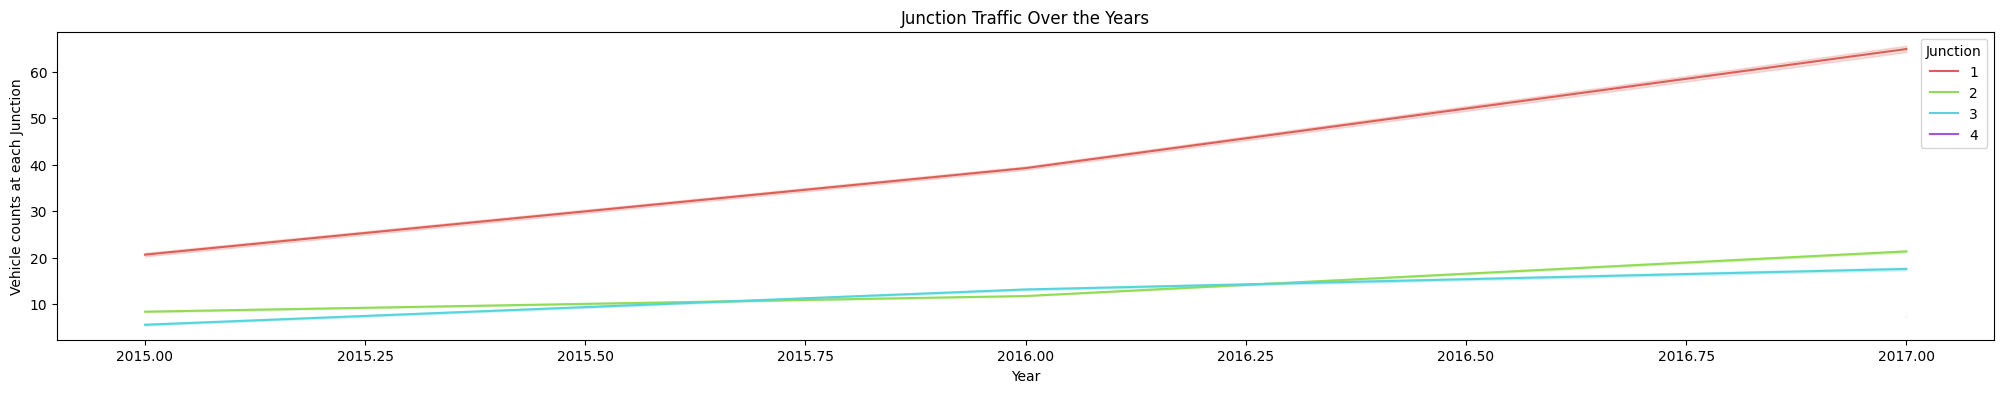

In [19]:
plt.figure(figsize=(25,4))
colors = sns.color_palette("hls", 4)
_ = sns.lineplot(x=df['Year'], y="Vehicles", data=df, hue="Junction", palette=colors)
_.set_title("Junction Traffic Over the Years")
_.set_ylabel("Vehicle counts at each Junction")
_.set_xlabel("Year")

##### We have already seen that traffic is increasing every year and more so at Junction-1

Text(0.5, 0, 'Date')

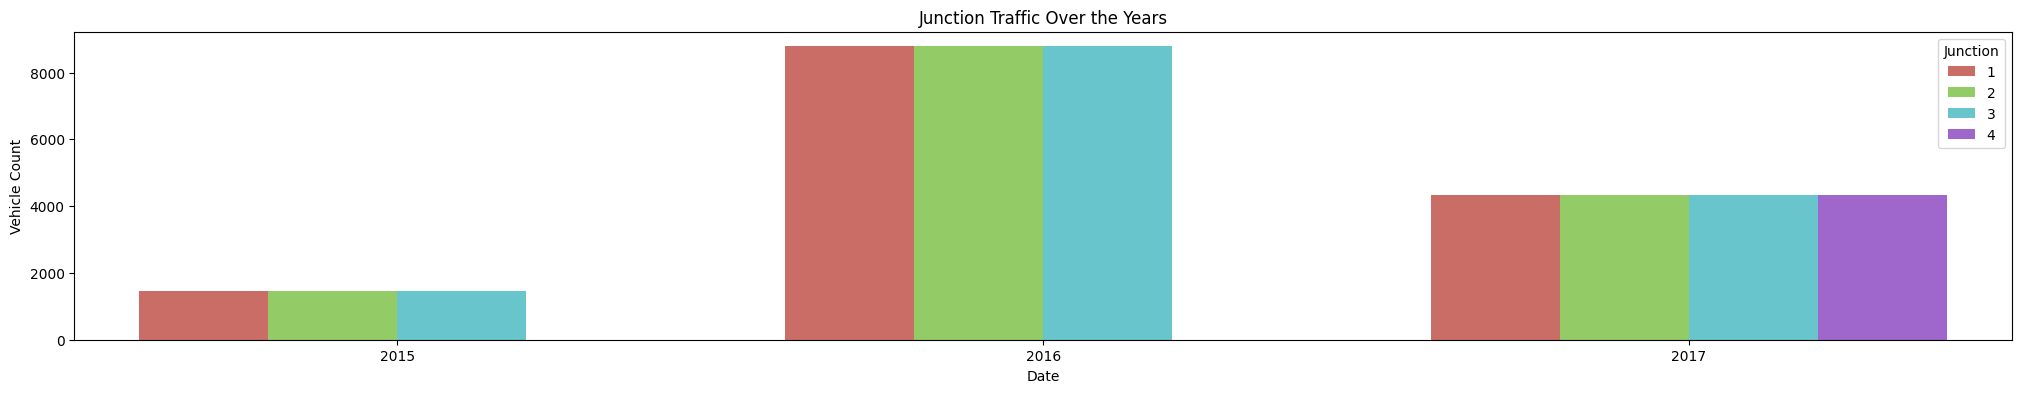

In [20]:
plt.figure(figsize=(25,4))
_ = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
_.set_title("Junction Traffic Over the Years")
_.set_ylabel("Vehicle Count")
_.set_xlabel("Date")

##### Again, traffic seems to be increasing from 2015 to 2016 but not so in 2017 and could be that we do not have full 2017 data

#### Checking Correlation

<AxesSubplot:>

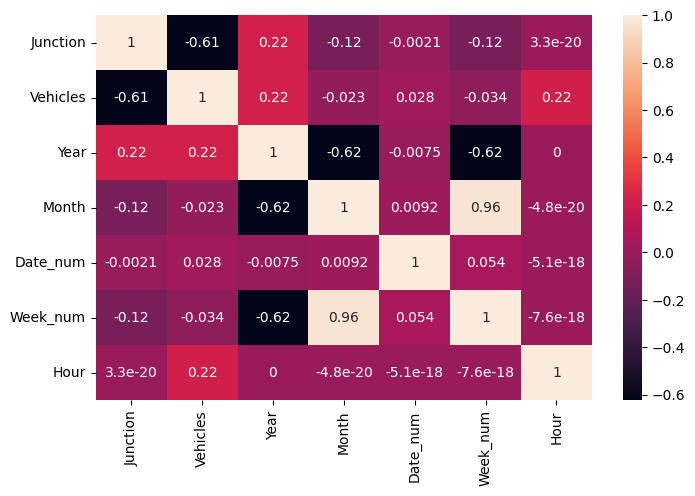

In [21]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(), annot=True)

##### Month and Week_num has a high correlation and we would be removing one of the variable before model building

#### This concludes the EDA. Output of EDA:
* All the junctions has different traffic pattern, hence we will predict each junction traffic separately. Also, the remedy will be be specific to each junctions.
* Some features has a high correlation and ned to be removed from data before model building.

#### Now we will check for Seasonality (above EDA clearly depict that there is some increasing trend presents for junctions) and if the time series is a Standard or not using DF test for all the Junctions separately

* constant mean
* constant variance
* an autocovariance that does not depend on time.

In [22]:
# Pivot data so that we can have the dataframe in the timeseries manner
df_p = df.pivot(columns="Junction", index="DateTime")

# separate timeseries by junctions
df_j1 = df_p[[('Vehicles', 1)]]
df_j2 = df_p[[('Vehicles', 2)]]
df_j3 = df_p[[('Vehicles', 3)]]
df_j4 = df_p[[('Vehicles', 4)]]

# remove missing values
df_j1 = df_j1.dropna() 
df_j2 = df_j2.dropna() 
df_j3 = df_j3.dropna() 
df_j4 = df_j4.dropna() 

In [23]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if round(dfoutput[0], 3) > round(dfoutput[4], 3):
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")

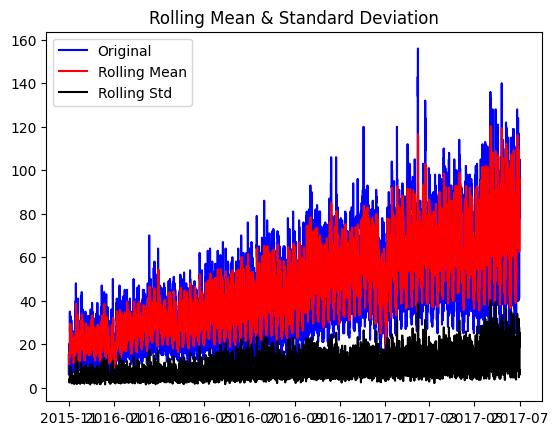

Results of Dickey-Fuller Test:
Test Statistic                -7.148078e+00
p-value                        3.193843e-10
#Lags Used                     4.200000e+01
Number of Observations Used    1.454900e+04
Critical Value (1%)           -3.430800e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64
Time Series is Stationary


In [24]:
test_stationarity(df_j1)

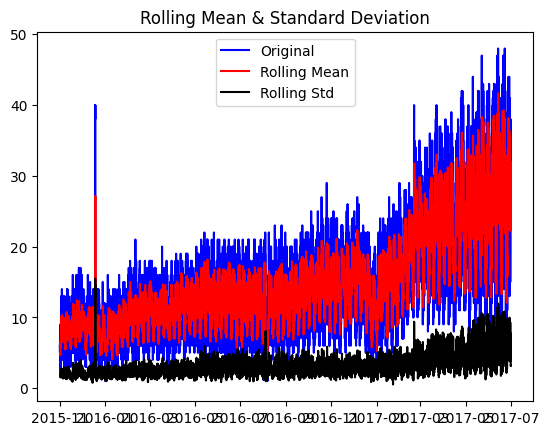

Results of Dickey-Fuller Test:
Test Statistic                -8.041077e+00
p-value                        1.846368e-12
#Lags Used                     4.200000e+01
Number of Observations Used    1.454900e+04
Critical Value (1%)           -3.430800e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64
Time Series is Stationary


In [25]:
test_stationarity(df_j2)

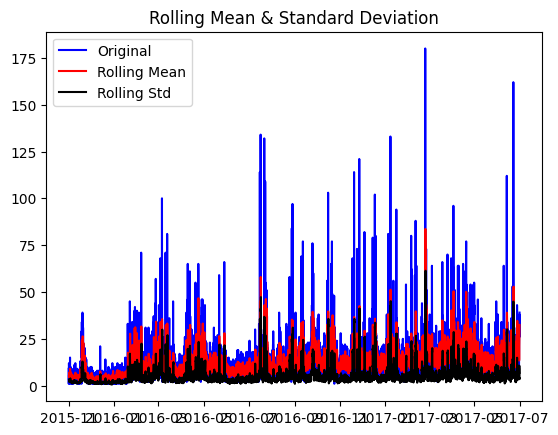

Results of Dickey-Fuller Test:
Test Statistic                -8.236600e+00
p-value                        5.867296e-13
#Lags Used                     4.200000e+01
Number of Observations Used    1.454900e+04
Critical Value (1%)           -3.430800e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64
Time Series is Stationary


In [26]:
test_stationarity(df_j3)

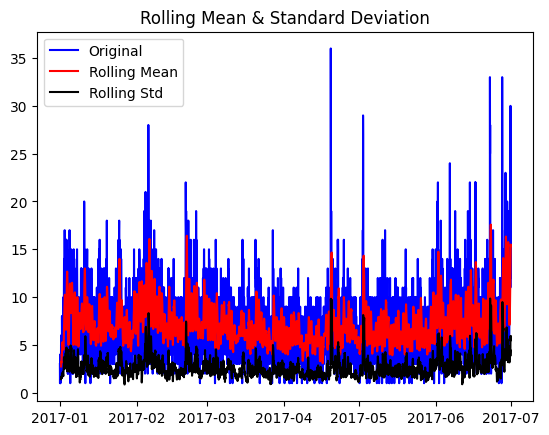

Results of Dickey-Fuller Test:
Test Statistic                -6.726732e+00
p-value                        3.374875e-09
#Lags Used                     3.000000e+01
Number of Observations Used    4.313000e+03
Critical Value (1%)           -3.431867e+00
Critical Value (5%)           -2.862210e+00
Critical Value (10%)          -2.567127e+00
dtype: float64
Time Series is Stationary


In [27]:
test_stationarity(df_j4)

##### * all the junctions dataframe are stationary but we see some trends, let's try with normalizing the data and then using differencing

#### Differencing
* One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity.

In [28]:
def Normalizing(timeseries):
    avg = timeseries['Vehicles'].mean()
    std = timeseries['Vehicles'].std()
    ts_norm = (timeseries['Vehicles'] - avg) / std
    return ts_norm

df_j1_norm = Normalizing(df_j1)
df_j2_norm = Normalizing(df_j2)
df_j3_norm = Normalizing(df_j3)
df_j4_norm = Normalizing(df_j4)

<AxesSubplot:xlabel='DateTime'>

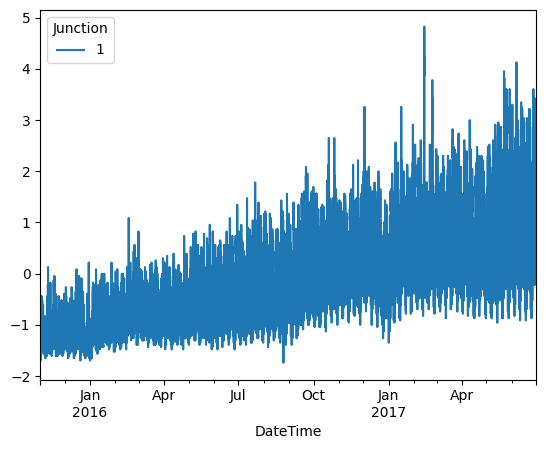

In [29]:
df_j1_norm.plot()

<AxesSubplot:xlabel='DateTime'>

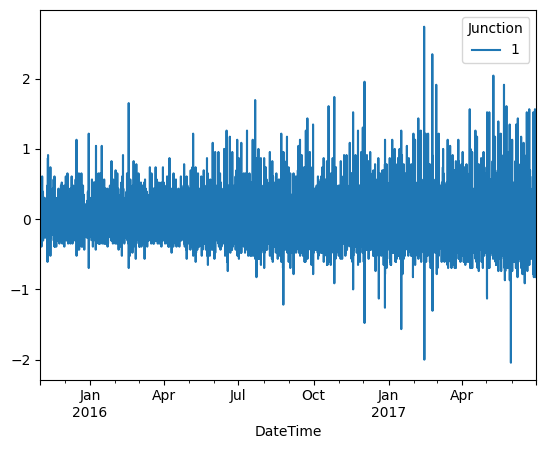

In [30]:
df_j1_norm.diff().plot()

<AxesSubplot:xlabel='DateTime'>

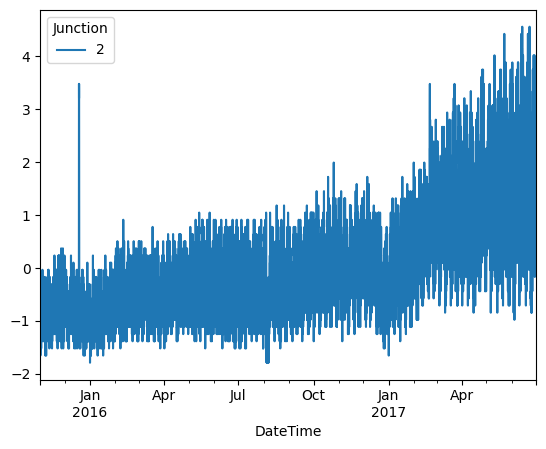

In [31]:
df_j2_norm.plot()

<AxesSubplot:xlabel='DateTime'>

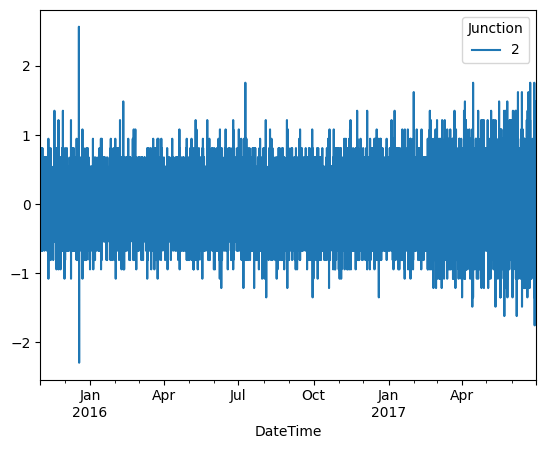

In [32]:
df_j2_norm.diff().plot()

<AxesSubplot:xlabel='DateTime'>

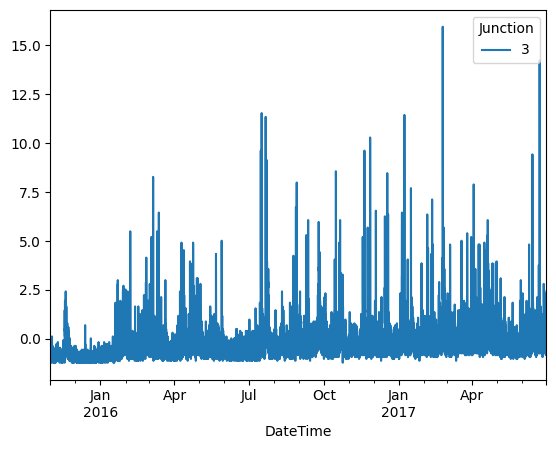

In [33]:
df_j3_norm.plot()

<AxesSubplot:xlabel='DateTime'>

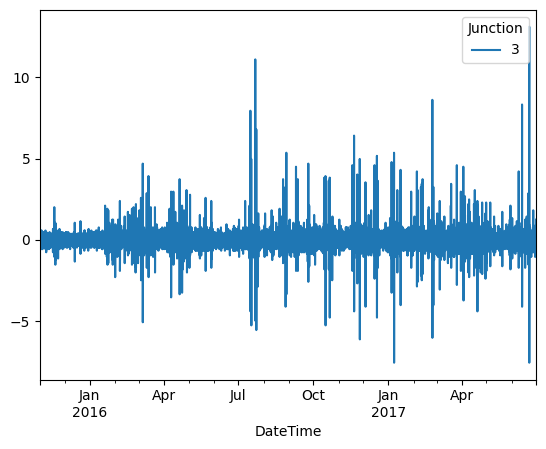

In [34]:
df_j3_norm.diff().plot()

<AxesSubplot:xlabel='DateTime'>

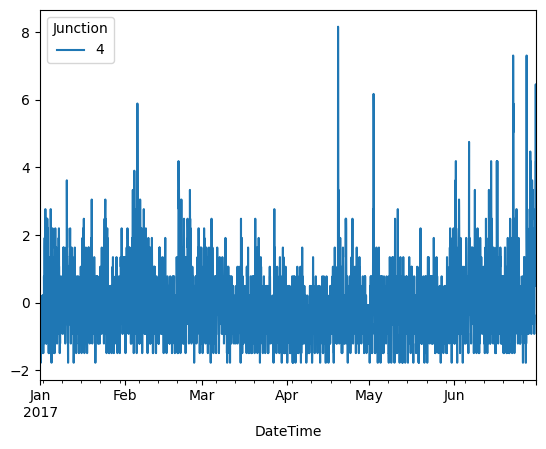

In [35]:
df_j4_norm.plot()

<AxesSubplot:xlabel='DateTime'>

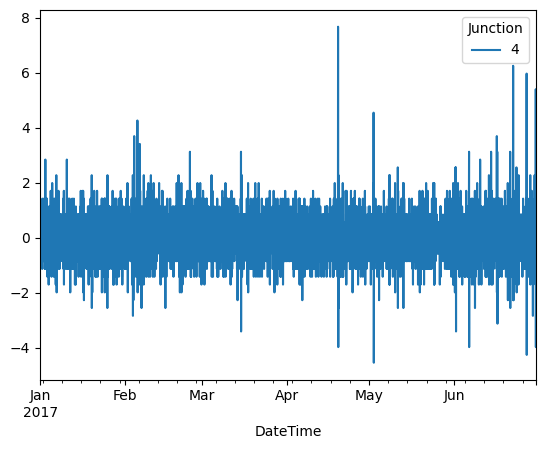

In [36]:
df_j4_norm.diff().plot()

In [44]:
#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.80)
    data_len = len(df)
    train, test = df[0:training_size], df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_j1_norm.diff().dropna())
J2_train, J2_test = Split_data(df_j2_norm.diff().dropna())
J3_train, J3_test = Split_data(df_j3_norm.diff().dropna())
J4_train, J4_test = Split_data(df_j4_norm.diff().dropna())

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 12
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

#### Model Building

In [45]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test, model_name):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True) 
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9), loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150, callbacks=[early_stopping])
#     model.save(model_name)
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

Epoch 1/50
78/78 [==============================] - 57s 411ms/step - loss: 0.0621
Epoch 2/50
78/78 [==============================] - 36s 459ms/step - loss: 0.0614
Epoch 3/50
78/78 [==============================] - 35s 447ms/step - loss: 0.0608
Epoch 4/50
78/78 [==============================] - 46s 588ms/step - loss: 0.0603
Epoch 5/50
78/78 [==============================] - 36s 466ms/step - loss: 0.0599
Epoch 6/50
78/78 [==============================] - 43s 552ms/step - loss: 0.0593
Epoch 7/50
78/78 [==============================] - 49s 629ms/step - loss: 0.0589
Epoch 8/50
78/78 [==============================] - 41s 526ms/step - loss: 0.0587
Epoch 9/50
78/78 [==============================] - 44s 562ms/step - loss: 0.0586
Epoch 10/50
78/78 [==============================] - 43s 554ms/step - loss: 0.0587
Epoch 11/50
78/78 [==============================] - 39s 508ms/step - loss: 0.0584
Epoch 12/50
78/78 [==============================] - 26s 336ms/step - loss: 0.0583
Epoch 13/50
7

Epoch 32/50
78/78 [==============================] - 33s 418ms/step - loss: 0.0570
Epoch 33/50
78/78 [==============================] - 42s 540ms/step - loss: 0.0571
Epoch 34/50
78/78 [==============================] - 26s 333ms/step - loss: 0.0570
Epoch 35/50
78/78 [==============================] - 26s 330ms/step - loss: 0.0571
Epoch 36/50
78/78 [==============================] - 26s 328ms/step - loss: 0.0568
Epoch 37/50
78/78 [==============================] - 26s 328ms/step - loss: 0.0571
Epoch 38/50
78/78 [==============================] - 30s 389ms/step - loss: 0.0570
Epoch 39/50
78/78 [==============================] - 45s 577ms/step - loss: 0.0569
Epoch 40/50
78/78 [==============================] - 28s 359ms/step - loss: 0.0569
Epoch 41/50
78/78 [==============================] - 24s 312ms/step - loss: 0.0567
Epoch 42/50
78/78 [==============================] - 32s 415ms/step - loss: 0.0568
Epoch 43/50
78/78 [==============================] - 37s 469ms/step - loss: 0.0568
Epoc

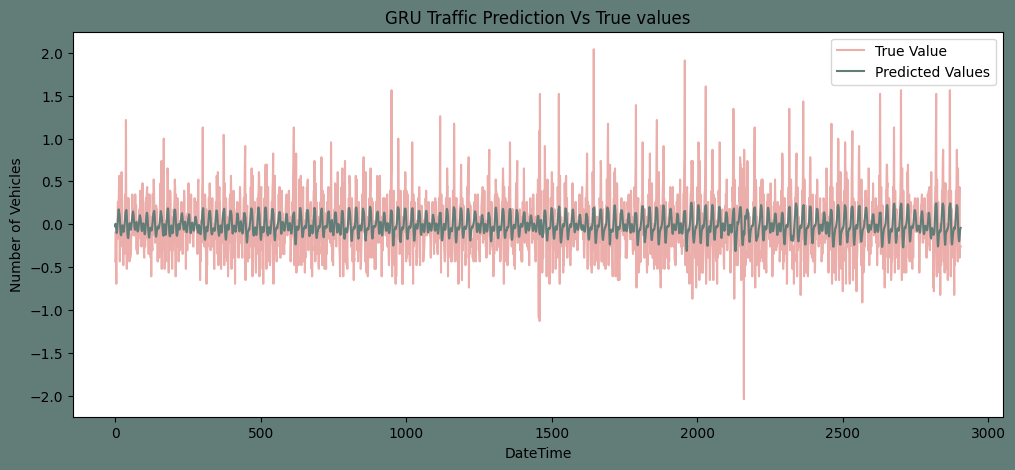

In [47]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1,y_testJ1)

#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

Epoch 1/50
78/78 [==============================] - 6s 10ms/step - loss: 0.1388
Epoch 2/50
78/78 [==============================] - 1s 10ms/step - loss: 0.1383
Epoch 3/50
78/78 [==============================] - 1s 10ms/step - loss: 0.1380
Epoch 4/50
78/78 [==============================] - 1s 10ms/step - loss: 0.1385
Epoch 5/50
78/78 [==============================] - 1s 10ms/step - loss: 0.1382
Epoch 6/50
78/78 [==============================] - 1s 11ms/step - loss: 0.1385
Epoch 7/50
78/78 [==============================] - 1s 10ms/step - loss: 0.1377
Epoch 8/50
78/78 [==============================] - 1s 10ms/step - loss: 0.1382
Epoch 9/50
78/78 [==============================] - 1s 10ms/step - loss: 0.1379
Epoch 10/50
78/78 [==============================] - 1s 10ms/step - loss: 0.1376
Epoch 11/50
78/78 [==============================] - 1s 10ms/step - loss: 0.1380
Epoch 12/50
78/78 [==============================] - 1s 10ms/step - loss: 0.1384
Epoch 13/50
78/78 [==================

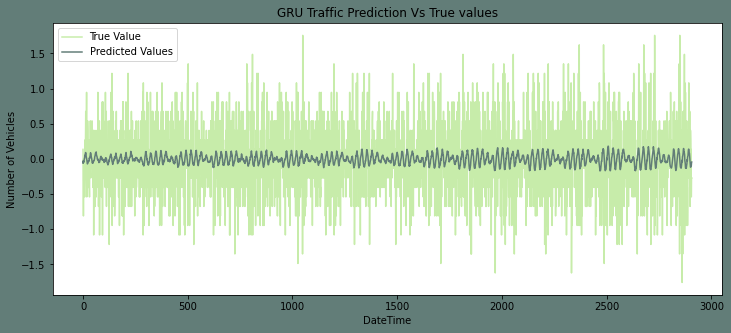

In [42]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

Epoch 1/50
78/78 [==============================] - 6s 10ms/step - loss: 0.2937
Epoch 2/50
78/78 [==============================] - 1s 10ms/step - loss: 0.2886
Epoch 3/50
78/78 [==============================] - 1s 10ms/step - loss: 0.2837
Epoch 4/50
78/78 [==============================] - 1s 11ms/step - loss: 0.2857
Epoch 5/50
78/78 [==============================] - 1s 13ms/step - loss: 0.2825
Epoch 6/50
78/78 [==============================] - 1s 12ms/step - loss: 0.2843
Epoch 7/50
78/78 [==============================] - 1s 11ms/step - loss: 0.2823
Epoch 8/50
78/78 [==============================] - 1s 10ms/step - loss: 0.2822
Epoch 9/50
78/78 [==============================] - 1s 10ms/step - loss: 0.2798
Epoch 10/50
78/78 [==============================] - 1s 10ms/step - loss: 0.2811
Epoch 11/50
78/78 [==============================] - 1s 10ms/step - loss: 0.2795
Epoch 12/50
78/78 [==============================] - 1s 10ms/step - loss: 0.2812
Epoch 13/50
78/78 [==================

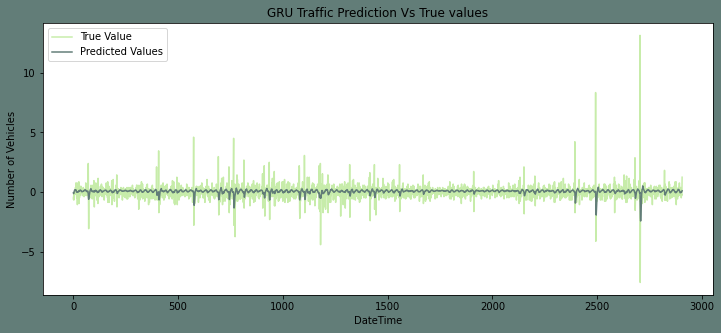

In [43]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3) 

#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,1)

Epoch 1/50
24/24 [==============================] - 6s 12ms/step - loss: 0.6803
Epoch 2/50
24/24 [==============================] - 0s 11ms/step - loss: 0.6889
Epoch 3/50
24/24 [==============================] - 0s 10ms/step - loss: 0.6787
Epoch 4/50
24/24 [==============================] - 0s 10ms/step - loss: 0.6762
Epoch 5/50
24/24 [==============================] - 0s 10ms/step - loss: 0.6754
Epoch 6/50
24/24 [==============================] - 0s 10ms/step - loss: 0.6752
Epoch 7/50
24/24 [==============================] - 0s 10ms/step - loss: 0.6732
Epoch 8/50
24/24 [==============================] - 0s 10ms/step - loss: 0.6729
Epoch 9/50
24/24 [==============================] - 0s 10ms/step - loss: 0.6699
Epoch 10/50
24/24 [==============================] - 0s 10ms/step - loss: 0.6739
Epoch 11/50
24/24 [==============================] - 0s 10ms/step - loss: 0.6709
Epoch 12/50
24/24 [==============================] - 0s 10ms/step - loss: 0.6801
Epoch 13/50
24/24 [==================

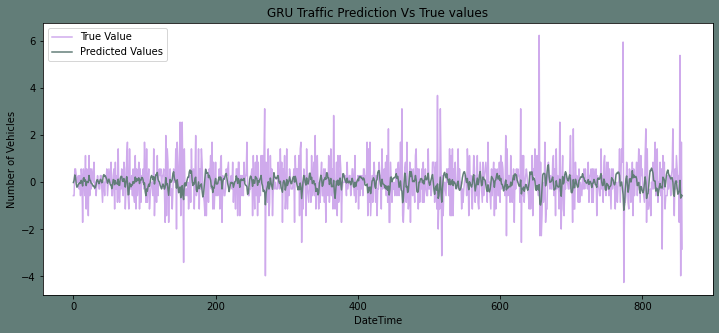

In [44]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

In [45]:
# getting all the RMSE's from Neural Network
print("Junction 1", round(RMSE_J1,4))
print("Junction 2", round(RMSE_J2,4))
print("Junction 3", round(RMSE_J3,4))
print("Junction 4", round(RMSE_J4,4))

Junction 1 0.3251
Junction 2 0.4984
Junction 3 0.6022
Junction 4 0.9545


### ARMA Model

In [46]:
!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA

     |████████████████████████████████| 1.4 MB 922 kB/s eta 0:00:01


In [49]:
j1_criteria = (pm.auto_arima(df_j1_norm))
j2_criteria = (pm.auto_arima(df_j2_norm))
j3_criteria = (pm.auto_arima(df_j3_norm))
j4_criteria = (pm.auto_arima(df_j4_norm))

print(j1_criteria, "\n", "/n", j2_criteria, "\n","/n", j3_criteria, "\n","/n", j4_criteria)

 ARIMA(2,1,2)(0,0,0)[0] intercept 
 /n  ARIMA(3,1,4)(0,0,0)[0]           
 /n  ARIMA(5,1,1)(0,0,0)[0]           
 /n  ARIMA(0,1,1)(0,0,0)[0]          


In [50]:
def arma_models(df, col, order):
    df = df.diff().dropna()
    df1 = pd.DataFrame(df, columns=[col]).rename(columns={col:'Vehicles'})
    model = ARIMA(df1, order=order)
    results_ARIMA = model.fit()
#     print(results_ARIMA.summary())
    
    results_ARIMA.plot_predict(start=len(df)-24)
    
    Errors = results_ARIMA.resid
#     print(Errors.tail())
    RMSE_ = (np.sqrt(np.mean((Errors)**2)))
    
    return Errors, RMSE_

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02509D-02    |proj g|=  7.44079D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     19      1     0     0   6.641D-03   8.023D-02
  F =   8.0232857842684802E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
DateTime
2015-11-01 02:00:00   -0.043462
2015-11-01 03:00:00   -0.019463
2015-11-01 04:00:00    0.206205
2015-11-01 05:00:00   -0.092894
2015-11-01 06:00:00    0.205623
                         ...   
2017-06-30 19:00:00    0.417644
2017-06-30 20:00:00   -0.500862
2017-06-30 21:00:00   -0.228080
2017-06-30 22:00:00   -0.178248
2017-06-30 23:00:00   -0.169279
Length: 14590, dtype: float64 0.26215533770185717
RUNNING THE 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     24      1     0     0   9.394D-01   4.612D-01
  F =  0.46115171437534197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


DateTime
2015-11-01 02:00:00   -0.135111
2015-11-01 03:00:00    0.184719
2015-11-01 04:00:00    0.186276
2015-11-01 05:00:00   -0.666168
2015-11-01 06:00:00    0.175593
                         ...   
2017-06-30 19:00:00    0.096851
2017-06-30 20:00:00    0.134327
2017-06-30 21:00:00   -0.499820
2017-06-30 22:00:00   -0.430420
2017-06-30 23:00:00   -0.373054
Length: 14590, dtype: float64 0.38369465419049925
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07058D+00    |proj g|=  1.67422D-05

At iterate    5    f=  1.07058D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final pro

 This problem is unconstrained.


DateTime
2015-11-01 02:00:00   -0.000066
2015-11-01 03:00:00   -0.191743
2015-11-01 04:00:00    0.385664
2015-11-01 05:00:00    0.137450
2015-11-01 06:00:00    0.049049
                         ...   
2017-06-30 19:00:00   -0.764201
2017-06-30 20:00:00   -0.039351
2017-06-30 21:00:00    0.044102
2017-06-30 22:00:00    0.049049
2017-06-30 23:00:00    1.483907
Length: 14590, dtype: float64 0.7058376333371197
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27207D+00    |proj g|=  1.79168D+00


 This problem is unconstrained.



At iterate    5    f=  1.27201D+00    |proj g|=  2.15422D-02

At iterate   10    f=  1.27200D+00    |proj g|=  3.07199D-01

At iterate   15    f=  1.27180D+00    |proj g|=  3.39605D+00

At iterate   20    f=  1.26951D+00    |proj g|=  7.98403D+00

At iterate   25    f=  1.26902D+00    |proj g|=  4.08572D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     44      1     0     0   4.926D-03   1.269D+00
  F =   1.2690089517603071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
DateTime
2017-01-01 02:00:00    1.419868
2017-01-01 03:00:00   -0.141987
2017-01-01 04:00:00   -0.662605
2017-01-

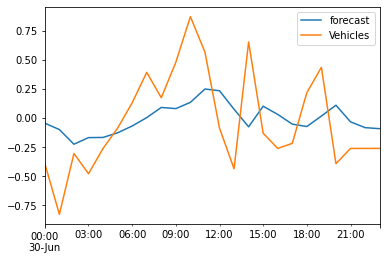

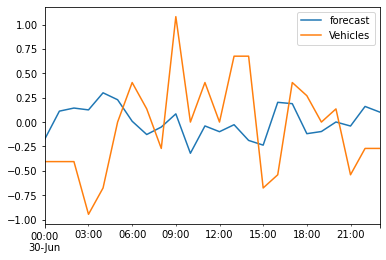

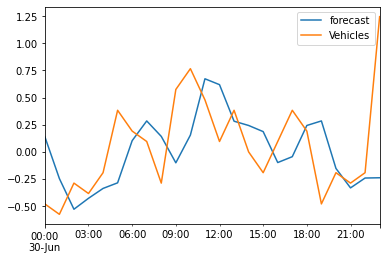

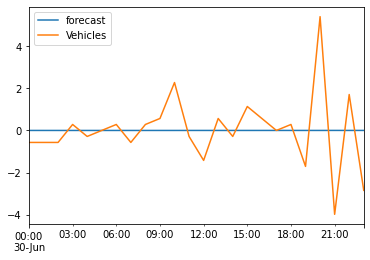

In [51]:
Error_J1, RMSE_J1 = arma_models(df_j1_norm, 1, (2,1,2))
print(Error_J1, RMSE_J1)

Error_J2, RMSE_J2 = arma_models(df_j2_norm, 2, (2,1,2))
print(Error_J2, RMSE_J2)

Error_J3, RMSE_J3 = arma_models(df_j3_norm, 3, (1,1,0))
print(Error_J3, RMSE_J3)

Error_J4, RMSE_J4 = arma_models(df_j4_norm, 4, (0,1,1))
print(Error_J4, RMSE_J4)

In [52]:
# getting all the RMSE's
print("Junction 1", round(RMSE_J1,4))
print("Junction 2", round(RMSE_J2,4))
print("Junction 3", round(RMSE_J3,4))
print("Junction 4", round(RMSE_J4,4))

Junction 1 0.2622
Junction 2 0.3837
Junction 3 0.7058
Junction 4 0.8607
